sample   super_pop  pop  epsilon
HG00732  AMR        PUR  99         6.11
Name: total_Hap2_bp_pct, dtype: float64
=== CLR summary
- mean  3.24
- stddev  0.54
count    30.000000
mean      2.925000
std       0.147198
min       2.740000
25%       2.802500
50%       2.880000
75%       3.035000
max       3.190000
Name: total_RefOnly_bp_pct, dtype: float64
count    30.000000
mean      2.980667
std       0.145126
min       2.790000
25%       2.870000
50%       2.935000
75%       3.092500
max       3.260000
Name: total_NonIllumina_bp_pct, dtype: float64
=== HiFi summary
- mean  3.22
- stddev  0.44
count    14.000000
mean      2.960000
std       0.134964
min       2.770000
25%       2.852500
50%       2.955000
75%       3.002500
max       3.190000
Name: total_RefOnly_bp_pct, dtype: float64
count    14.000000
mean      3.002143
std       0.126441
min       2.810000
25%       2.905000
50%       2.990000
75%       3.055000
max       3.220000
Name: total_NonIllumina_bp_pct, dtype: float64


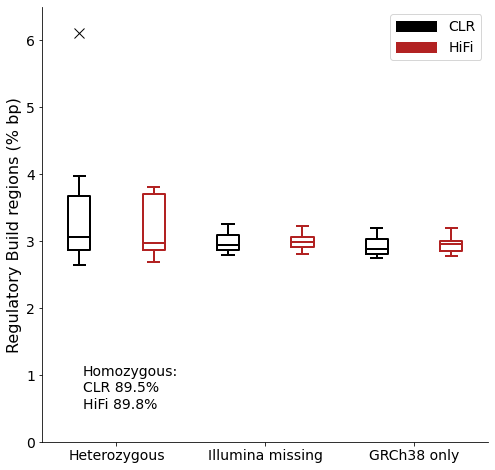

In [13]:
import os
import collections as col
import importlib
import re

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()
prop = plot_aux.get_plot_property

save_plots = True
print_stats = True

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/figSX_panels/missing_regulatory'
out_path = os.path.join(stats_path, pipeline_version, 'figSX_panel_regb')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))


def load_regb_stats(file_path):

    df = pd.read_csv(file_path, sep='\t', header=None, names=['value'], index_col=[0])
    df = df.transpose()
    for c in df.columns:
        if c.endswith('_pct'):
            df[c] = df[c].astype('float64')
        else:
            df[c] = df[c].astype('int64')
    return df


if not os.path.isfile(cache_file):
    stats_files = plot_aux.load_plot_data_files(
        stats_path,
        '.stats.tsv',
        pipeline_version)
    stats_data = [load_regb_stats(fp) for fp in stats_files]
    
    sample_platform = [
        plot_aux.extract_sample_platform(os.path.basename(f), multi_readset=True) for f in stats_files
    ]

    row_index = []
    for sample, platform in sample_platform:
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform, 99))
    row_index = pd.MultiIndex.from_tuples(
        row_index,
        names=['sample', 'super_pop', 'pop', 'platform', 'epsilon']
    )
    df = pd.concat(stats_data, axis=0)
    df.index = row_index
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform'])


def plot_regb_statistic(sample_stats):
    
    bar_width = prop('bar_width')

    categories = [
        'Heterozygous',
        'Illumina missing',
        'GRCh38 only'
    ]
    
    selectors = {
        'Heterozygous': ['total_Hap1_bp_pct', 'total_Hap2_bp_pct'],
        'Illumina missing': ['total_NonIllumina_bp_pct'],
        'GRCh38 only': ['total_RefOnly_bp_pct']
    }
    
    properties = {
        'HiFi': {'color': 'red'}
    }
    
    x_pos_counter = 0
    
    hom_stats = {
        'CLR': [],
        'HiFi': []
    }
    
    fig, axis = plt.subplots(figsize=(8,8))
    
    for category in categories:
        
        for platform in ['CLR', 'HiFi']:
            dist_values = []
            
            subset = sample_stats.xs(platform, level='platform')
            
            if category == 'Heterozygous' and platform == 'CLR':
                print(subset.loc[subset['total_Hap2_bp_pct'] > 5, 'total_Hap2_bp_pct'])
            
            hom_stats[platform] = subset['total_HapBoth_bp_pct']
            
            for selector in selectors[category]:
                
                dist_values.extend(subset[selector].values.tolist())
                
            axis.boxplot(
                dist_values,
                notch=False,
                sym='x',
                widths=bar_width,
                positions=[x_pos_counter],
                boxprops={
                    'color': plot_aux.get_platform_color(platform),
                    'linewidth': 2
                },
                meanprops={
                    'color': plot_aux.get_platform_color(platform),
                    'linewidth': 2
                },
                medianprops={
                    'color': plot_aux.get_platform_color(platform),
                    'linewidth': 2
                },
                whiskerprops={
                    'color': plot_aux.get_platform_color(platform),
                    'linewidth': 2
                },
                flierprops={
                    'color': plot_aux.get_platform_color(platform),
                    'linewidth': 2,
                    'markersize': 10
                },
                capprops={
                    'color': plot_aux.get_platform_color(platform),
                    'linewidth': 2
                }
            )
            x_pos_counter += 1
    
    
#     axis.set_xlabel(
#         'Samples',
#         fontsize=prop('fontsize_axis_label')
#     )
    axis.set_ylabel(
        'Regulatory Build regions (% bp)',
        fontsize=prop('fontsize_axis_label')
    )
    axis.set_ylim(0, 6.5)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

    axis.set_xticks([0.5, 2.5, 4.5])
    axis.set_xticklabels(categories)
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    # build custom legend
    custom_patches = [
        patches.Patch(
            facecolor=plot_aux.get_platform_color('CLR'),
            edgecolor='white',
            label='CLR'
        ),
        patches.Patch(
            facecolor=plot_aux.get_platform_color('HiFi'),
            edgecolor='white',
            label='HiFi',
        ),
    ]
    
    axis.legend(
        handles=custom_patches,
        loc='upper right',
        handlelength=3,
        handleheight=1,
        prop={'size': prop('fontsize_legend')}
    )
    
    hom_stats['HiFi'] = np.array(hom_stats['HiFi'], dtype=np.float64)
    hom_stats['CLR'] = np.array(hom_stats['CLR'], dtype=np.float64)
    
    hom_text = 'Homozygous:\nCLR {}%\nHiFi {}%'.format(
        hom_stats['CLR'].mean().round(1),
        hom_stats['HiFi'].mean().round(1)
    )
    
    axis.text(
        x=0.05,
        y=0.5,
        s=hom_text,
        fontdict={'size': prop('fontsize_legend')}
    )
        
    extra_artists = []
    
    return fig, extra_artists

fig, exart = plot_regb_statistic(df)

if save_plots:
    fig.savefig(out_path + '.png', dpi=600, bbox_inches='tight', extra_artists=exart)
    fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
    
if print_stats:
    for platform in ['CLR', 'HiFi']:
        subset = df.xs(platform, level='platform')
        data_values = []
        for s in ['total_Hap1_bp_pct', 'total_Hap2_bp_pct']:
            data_values.extend(subset[s].values.tolist())
        print('=== {} summary'.format(platform))
        data_values = np.array(data_values, dtype=np.float64)
        print('- mean ', data_values.mean().round(2))
        print('- stddev ', data_values.std().round(2))
    
        print(subset['total_RefOnly_bp_pct'].describe())
        print(subset['total_NonIllumina_bp_pct'].describe())